In [456]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import scipy.misc as mis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

deg_k_smooth_spl = 10
extra_spl = 0 # 0 extrapolation , 1 zero; 2 error; 3 boundary values
interp_spl = lambda space, funct : interp.UnivariateSpline(space, funct, k=deg_k_smooth_spl, ext=extra_spl)

interp_funct = lambda space, funct : interp.interp1d(space, funct, kind='linear', fill_value='extrapolate')

The isotropic metric in spherical coordinates is

$\mathrm{d}s^2 = -N^2(t,r) \mathrm{d}t^2 + \psi^4(t,r)\big(\mathrm{d}r^2 + r^2\mathrm{d}\theta^2 + r^2\sin^2\theta\,\mathrm{d}\phi^2\big)$,

and the matter Lagrangian is a free scalar field,

$\mathcal{L}_{\text{matter}} = -\frac{1}{2}(\partial_\mu \phi)^2-\frac{1}{2}q^2\,A_\mu^2\phi^2-\frac{1}{4}\lambda (\phi^2-2v^2)^2-\frac{1}{4}|F_{\mu\nu}|^2$.

Define the conjugate of momentum for $\chi$ to be $p$ and the constant time 3D extrinsic curvature be $K$. Here, $\kappa^2 = 8\pi G_{\text{N}}$. The 7 equations of motions are, from top to bottom, definition of $p$, EOM for $\chi$, definition of $K$, the Einstein's equations for $G_{rt}$, $\frac{1}{\psi^4}G_{rr}+\frac{1}{N^2}G_{tt}$, $G_{tt}$ and $\frac{1}{r^2}G_{\theta\theta}-G_{rr}$:

1. $\dot{\phi} = \frac{N}{\psi^6}p$,

2. $\dot{p} = \frac{1}{r^2}\partial_r(r^2N\psi^2\phi')-\lambda \psi^6 N\phi(\phi^2-2v^2) + q^2\phi(\frac{\psi^6}{N}A_t^2 - \psi^2 N A_r^2 )$,

3. $\dot{\psi} = -\frac{N\psi K}{6}$,

4. $\frac{K'}{3} = \frac{\kappa^2}{2}\Big(\frac{\phi' p}{\psi^6} + \frac{q^2 A_r A_t \phi^2}{N}\Big)$,

5. $\frac{\dot{K}}{N} = K^2-\frac{6\psi'}{\psi^5}\Big(\frac{\psi'}{\psi}+\frac{1}{r}\Big) - \frac{3N'}{N\psi^4}\Big(\frac{2\psi'}{\psi} + \frac{1}{r}\Big)-\frac{6}{r\psi^5}(2\psi'+r\psi'')- 3\kappa^2 \Big( \frac{1}{2}\frac{1}{N^2 \psi^4}(\partial_t A_r - \partial_r A_t)^2 + \frac{\lambda}{4}(\phi^2-2v^2)^2\Big)$,

6. $-\frac{4}{r\psi^5}(2\psi'+r\psi'') = \frac{\kappa^2}{2}\Big(\frac{\phi'^2+q^2 A_r^2 \phi^2}{\psi^4} +\frac{p^2}{\psi^{12}}+ \frac{(\partial_t A_r -\partial_r A_t)^2 + q^2 A_t^2 \phi^2}{\psi^4 N^2} +\frac{\lambda}{2}(\phi^2-2v^2)^2\Big)-\frac{K^2}{3}$,

7. $\frac{2r}{\psi^2}\partial_r\Big(\frac{\psi'}{r\psi^3}\Big) +\frac{r}{N}\partial_r\Big(\frac{N'}{r\psi^4}\Big)=-\frac{\kappa^2}{\psi^4}\Big[ \phi'^2 +q^2A_r^2\phi^2 -\frac{1}{N^2}(\partial_t A_r -\partial_r A_t)^2 \Big]$.

In [457]:
kap = 0.5
lamb = 3.
vev = 0.0
#m2chi = 1.

kapsq = kap**2
vevsq=vev**2

m_schwarz = 4.0
r_min = 4.5
r_max = 1000
r_div = int(1e6)/10

## One dimensional radial action

We approach this problem as a 1-dimension ODE. We define the velocity fields $A$ abd $B$ for simplifying the equations. The order of the equations are also the order of the ODEint variables in the I/O vector.

$A' = \frac{r^2 \psi^5 K^2}{12} - \frac{r^2 \kappa^2}{8}\Big( \psi(\phi'^2 + q^2A_r^2\phi^2) + \frac{p^2}{\psi^7} + \frac{\psi^5}{N^2} q^2A_t^2\phi^2 + \frac{\psi}{N^2}(\partial_r A_t - \partial_t A_r)^2 + \psi^5 \frac{\lambda}{2}(\phi^2-2v^2)^2 \Big) $

$B' = \frac{N}{r}\Big(\frac{6A}{r^3\psi^5} + \frac{6A^2}{r^4 \psi^6} - \frac{K^2}{6}\Big) + \frac{\kappa^2}{4r} \big( \frac{N}{\psi^{12}}p^{2} + \frac{1}{N}q^2A_t^2\phi^2 - \frac{3N}{\psi^4}(\phi'^2 + q^2A_r^2\phi^2) + \frac{5}{N\psi^4}(\partial_rA_t - \partial_tA_r)^2 + \frac{\lambda}{2}N(\phi^2-2v^2)^2\big)$

$\psi' = \frac{A}{r^2}$

$N' = rB\psi^4$

$a' = -q^2 \frac{r^2 \psi^6}{N} A_t \phi^2$

The first two equations are from Eq. 6 and Eq. 7 respectively. The last two equations are the defining equations for $A$ and $B$. At $t=0$, $K=0$.

In [458]:
def dA_dr(r, N, psi, K, phi, p, phi_dr, vevsq, ar = None, ar_dt = None, at_dr = None):
    if ar is None and ar_dt is None and at_dr is None:
        A_r = (r **2)*(psi**5)*(K**2)/12. - kapsq*(r**2)*(psi*phi_dr**2 \
                    + (p**2)/(psi**7) + (lamb/2.)*(psi**5)*(phi**2 - 2*vevsq)**2 )/8.
    else:
        A_r = (r **2)*(psi**5)*(K**2)/12. - kapsq*(r**2)*(psi*phi_dr**2 + (q**2)*(ar**2)*(phi**2) \
                + (p**2)/(psi**7) + (a**2)/((r**4)*psi*N) + (lamb/2.)*(psi**5)*(phi**2 - 2*vevsq)**2 )/8.
    return A_r

def dB_dr(r, A, N, psi, K, phi, p, phi_dr, vevsq, ar = None, at = None, ar_dt = None, at_dr = None):
    if ar is None and at is None and ar_dt is None and at_dr is None:
        B_r = N*( 6.*A/((r**3)*(psi**5)) + 6.*(A**2)/((r**4)*(psi**6)) - K**2/6.)/r + \
           (kapsq/4.)*N*((p**2)/(psi**12) - 3.*(phi_dr**2)/(psi**4) + (lamb/2.)*(phi**2-2*vevsq)**2)/r
    else:
        B_r = N*( 6.*A/((r**3)*(psi**5)) + 6.*(A**2)/((r**4)*(psi**6)) - K**2/6.)/r + \
           (kapsq/4.)*N*((p**2)/(psi**12) + (q**2)*(at**2)*phi**2/N - \
            3.*N*(phi_dr**2 + (q**2)*(ar**2)*(phi**2))/(psi**4) + 5*(a**2)/((r**3)*N*(psi**6))
            + (lamb/2.)*N*(phi**2-2*vevsq)**2)/r
    return B_r

def dpsi_dr(r, A):
    psi_r = A/(r**2)
    return psi_r

def dN_dr(r, B, psi):
    N_r = r*B*psi**4
    return N_r

def fun_r(r, y, ext_val):
    A_in = y[0]; B_in = y[1]; psi_in = y[2]; N_in = y[3];
    vev_val = ext_val[0]; phi_in = ext_val[1]; p_in = ext_val[2]; phi_dr_in = ext_val[3]; K_in = ext_val[4]

    A_out = dA_dr( r, N_in, psi_in, K_in(r), phi_in(r), p_in(r), phi_dr_in(r), vev_val)
    B_out = dB_dr( r, A_in, N_in, psi_in, K_in(r), phi_in(r), p_in(r), phi_dr_in(r) , vev_val)
    psi_out = dpsi_dr(r, A_in)
    N_out = dN_dr(r, B_in, psi_in)
    
    return [A_out, B_out, psi_out, N_out]

First, we define the spatial grid $r$ and the initial condition for the scalar field $\phi(0,r)$,

$\phi(r) = 0$,

$\phi'(r) = 0$,

$p(r) = \frac{\psi^6}{N}\dot{\phi}(r) = \psi^6 \epsilon$.

The $\epsilon$ is a small, spatial independent, initial momentum to push the field towards one of the SSB vaccua.

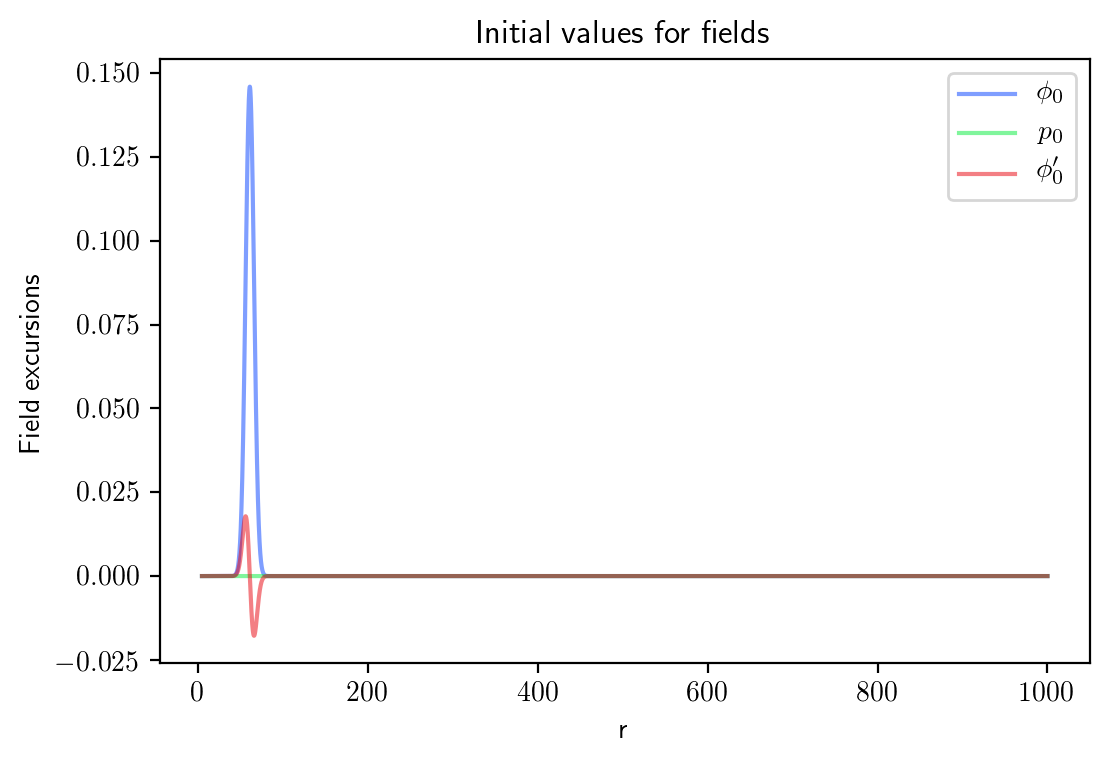

In [466]:
rr = np.linspace(r_min, r_max, r_div)

phi_init_grid = 0.00004*np.exp(-(rr-60.)**2/50.)*rr**2 #8.*lamb*(rr**4)/((lamb**2)+(rr**2))**4
p_init_grid = 0.*rr
phi_dr_init_grid = 0.00004*(2*rr - 2.*(rr-60)*(rr**2/50))*np.exp(-(rr-60.)**2/50.) #32.*lamb*(rr**3)/((lamb**2)+(rr**2))**4 - 64.*lamb*(rr**5)/((lamb**2)+(rr**2))**5
K_init_grid = 0.*rr
ar_init = 0.*rr
at_init = q/rr

phi_init = interp_funct(rr, phi_init_grid)
p_init = interp_funct(rr, p_init_grid)
phi_dr_init = interp_funct(rr, phi_dr_init_grid)
K_init = interp_funct(rr, K_init_grid)

plt.xlabel('r'); plt.ylabel('Field excursions'); plt.title('Initial values for fields');
plt.plot(rr, phi_init(rr) , label='$\phi_{0}$', alpha=0.5)
plt.plot(rr, p_init(rr), label ='$p_{0}$', alpha=0.5)
plt.plot(rr, phi_dr_init(rr), label ='$\phi\'_{0}$', alpha=0.5)
#plt.plot(rr, chi_init_grid , label='$\chi_{0}$ grid points', alpha=0.5)
#plt.plot(rr, chi_dt_init_grid, label ='$\dot{\chi}_{0}$ grid points', alpha=0.5)
plt.legend(); plt.show()

The analytic Black Hole solution which will gives the boundary condition to the metric

$\mathrm{d}s^2 = \displaystyle-\Bigg(\frac{1-\frac{M}{2r}}{1+\frac{M}{2r}}\Bigg)^2 \mathrm{d}t^2 + \Big(1+\frac{M}{2r}\Big)^4(\mathrm{d}r^2+r^2\mathrm{d}\Omega^2)$.

The transformation between the isotropic coordinates $r$ and the schwarzchild coordinates $r_{\text{sch}}$ is

$r_{\text{sch}} = r\Big(1+\frac{m}{2r}\Big)^2$.

First, we set all matter fields to 0 everywhere. Then we solve the metric from small $r$ using the exact metric numerical value as initial conditions.

In [471]:
N_s = lambda r: (1.-m_schwarz/(2.*r))/(1.+m_schwarz/(2.*r))
N_r_s = lambda r: m_schwarz/(r + m_schwarz/2.)**2
psi_s = lambda r: 1+m_schwarz/(2.*r)
psi_r_s = lambda r: -m_schwarz/(2.*(r)**2)

def likelihood_dist(r_b, A_b, B_b, psi_b, N_b, bounds, offsets = None):
    A_bnd = bounds[0]; B_bnd = bounds[1]; psi_bnd = bounds[2]; N_bnd = bounds[3];
    if offsets is None:
        dist = ((A_b/(r_b**2))/A_bnd)**2 + (r_b*(psi_b**4)*B_b/B_bnd)**2 \
                + ((psi_b-1.)/psi_bnd)**2 + ((N_b-1.)/N_bnd)**2
    else:
        A_off = offsets[0]; B_off = offsets[1]; psi_off = offsets[2]; N_off = offsets[3];
        dist = ((A_b/(r_b**2) - A_off)/A_bnd)**2 + ((r_b*(psi_b**4)*B_b - B_off)/B_bnd)**2 \
                + ((psi_b - psi_off)/psi_bnd)**2 + ((N_b - N_off)/N_bnd)**2
    return dist
    
def shoot_r(init_input, r, bounds, offsets = None, reverse = False):
    if reverse:
        r_i = r[-1]; r_f = r[0];
        ret_full = nint.solve_ivp(fun_r_solve, (r_i, r_f), init_input, method='RK45',\
                                  t_eval=r[::-1], rtol=1e-6, atol=1e-8)
    else:
        r_i = r[0]; r_f = r[-1];
        ret_full = nint.solve_ivp(fun_r_solve, (r_i, r_f), init_input, method='RK45',\
                                  t_eval=r, rtol=1e-6, atol=1e-8)
    if not ret_full.success:
        return np.inf
    A_out = ret_full.y[0]; B_out = ret_full.y[1]; psi_out = ret_full.y[2]; N_out = ret_full.y[3];
    dist = likelihood_dist(r_f, A_out[-1], B_out[-1], psi_out[-1], N_out[-1], bounds, offsets)  
    return dist

The ODE system accept an input $\vec{\text{input}} = (\vec{\text{var}}; \vec{\text{aux}})$

Our variable vector to solve this 1D ODE is $\vec{\text{var}} = \begin{pmatrix} A \\ B \\ \psi \\ N  \end{pmatrix}$.

The auxiliary input is $\vec{\text{aux}} = \begin{pmatrix} \chi \\ p \\ \chi'  \end{pmatrix}$, which will be fully dynamical when we evolve the system in time.

First of all, let's examine the "initial guess". The default tolerance of the RK4 solver is rtol = 1e-3, atol = 1e-6.

CPU times: user 96.2 ms, sys: 4.33 ms, total: 101 ms
Wall time: 99.7 ms
number of steps of r: 100000


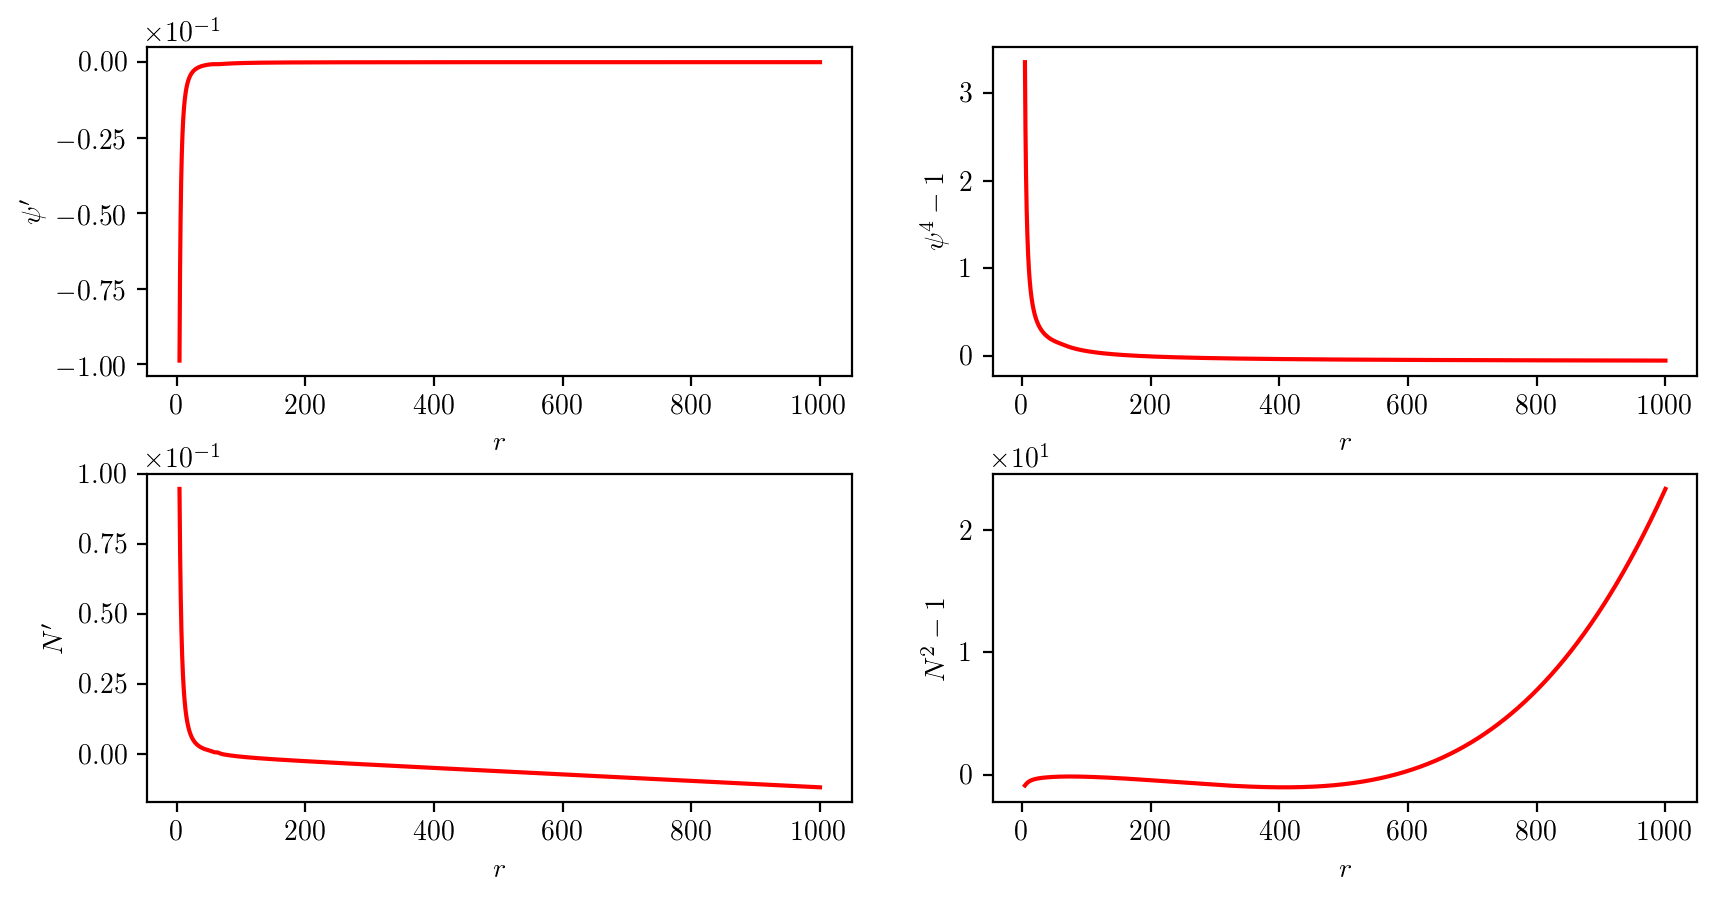

In [472]:
init_input = np.array([psi_r_s(r_min)*r_min**2, N_r_s(r_min)/(r_min*psi_s(r_min)**4), psi_s(r_min), N_s(r_min)])
r_i = rr[0]; r_f = rr[-1];

fun_r_solve = lambda r, y: fun_r(r, y, [vevsq, phi_init, p_init, phi_dr_init, K_init])

%time ret_full = nint.solve_ivp(fun_r_solve, (r_i,r_f), init_input, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-8)
if not ret_full.success: print "INTEGRATION FAILED!"
    
A_out = ret_full.y[0]; B_out = ret_full.y[1]; psi_out = ret_full.y[2]; N_out = ret_full.y[3];

print "number of steps of r: "+ str(len(ret_full.t))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[0,0].plot(ret_full.t, A_out/(ret_full.t**2), label='$A$',color='red'); ax[0,0].set_ylabel('$\psi\'$');
ax[1,0].plot(ret_full.t, ret_full.t*B_out*(psi_out**4), label='$B$',color='red'); ax[1,0].set_ylabel('$N\'$')
ax[0,1].plot(ret_full.t, psi_out**4-1., label='$\psi$',color='red'); ax[0,1].set_ylabel('$\psi^4 - 1$')
ax[1,1].plot(ret_full.t, N_out**2-1., label='$N$',color='red'); ax[1,1].set_ylabel('$N^2 - 1$')



plt.show()

In [473]:
reverse_bnd = False

if not reverse_bnd:
    offs = [psi_r_s(r_max), N_r_s(r_max), psi_s(r_max), N_s(r_max)]
    bnd_dnf = lambda n: rr[-1]**n
    #bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]
    bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.)]
else:
    offs = [psi_r_s(r_min), N_r_s(r_min), psi_s(r_min), N_s(r_min)]
    bnd_dnf = lambda n: rr[0]**n
    bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]

if not reverse_bnd:
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs), method='Powell', \
                                options={'xtol':1e-6, 'ftol':1e-8})
else:
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-6, 'ftol':1e-8})
if result["success"]:
    print("Success!")
    
x_return = result["x"]
print("The optimized inital values are: " + str(x_return))
print("The result distance is: " + str(result["fun"]))

if not reverse_bnd:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_min , r_max), x_return, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-8)
else:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_max , r_min), x_return, method='RK45', t_eval=rr[::-1], rtol=1e-6, atol=1e-8)
A_out = ret_full.y[0]; B_out = ret_full.y[1]; psi_out = ret_full.y[2]; N_out = ret_full.y[3];

CPU times: user 1min 6s, sys: 684 ms, total: 1min 7s
Wall time: 1min 6s
Success!
The optimized inital values are: [-1.96354363  0.00467809  1.45308219  0.39876472]
The result distance is: 2.20244379463e-08
CPU times: user 61.6 ms, sys: 655 µs, total: 62.2 ms
Wall time: 61.5 ms


We now run the RK4 ODE-solver in full.

We use the shooting method from $r \simeq 0$ to $r = R \gg 1$. Our target at $R$ is the flat space metric. Our uncertainty in the boundary metric from $R\neq \infty$ is due to the Schwarzchild component of the matter field, namely,

$N = \displaystyle\frac{1-\frac{M}{2R}}{1+\frac{M}{2R}} \approx 1-\frac{M}{R}+ O(\frac{1}{R^2})$,

$\psi = 1+\frac{M}{2R}$,

$N' = \displaystyle\frac{M}{(1+\frac{M}{2R^2})R^2} \approx \frac{M}{R^2}+ O(\frac{1}{R^3})$

$\psi' = - \frac{M}{2 R^2}$

which gives the uncertainty $(N-1) \approx (\psi-1) \sim O\Big(\frac{1}{R}\Big)$ and their derivatives $N' \approx \psi' \sim O\Big(\frac{1}{R^2}\Big)$.

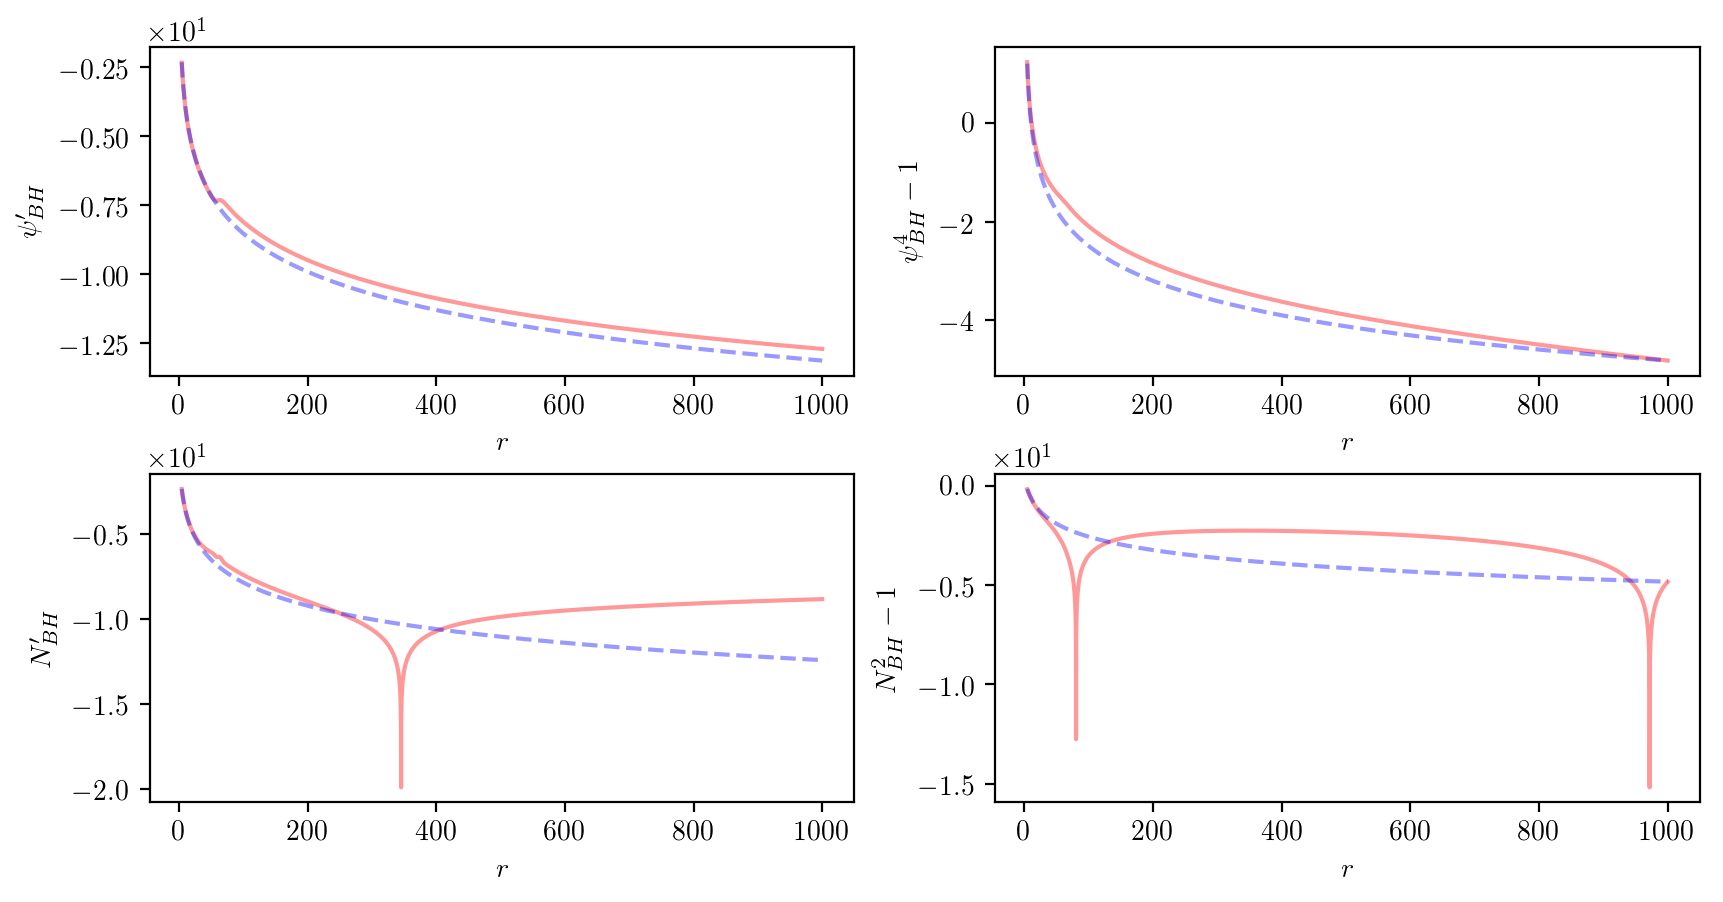

In [474]:
r_i = rr[0]; r_f = rr[-1];

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

logit = lambda x: np.log(np.abs(x))
        
ax[0,0].plot(ret_full.t, logit(A_out/(ret_full.t**2)), label='$psip$',color='red', alpha=0.4); ax[0,0].set_ylabel('$\psi\'$');
ax[0,0].plot(ret_full.t, logit(psi_r_s(ret_full.t)), label='$psipBH$',color='blue', linestyle='--',alpha=0.4); ax[0,0].set_ylabel('$\psi\'_{BH}$');

ax[1,0].plot(ret_full.t, logit(ret_full.t*B_out*(psi_out**4)), label='$Np$',color='red', alpha=0.4); ax[1,0].set_ylabel('$N\'$');
ax[1,0].plot(ret_full.t, logit(N_r_s(ret_full.t)), label='$NpBH$',color='blue', linestyle='--',alpha=0.4); ax[1,0].set_ylabel('$N\'_{BH}$');

ax[0,1].plot(ret_full.t, logit(psi_out**4-1.), label='$\psi$',color='red', alpha=0.4); ax[0,1].set_ylabel('$\psi^4 - 1$');
ax[0,1].plot(ret_full.t, logit(psi_s(ret_full.t)**4-1.), label='$\psiBH$',color='blue', linestyle='--', alpha=0.4); ax[0,1].set_ylabel('$\psi^4_{BH} - 1$');

ax[1,1].plot(ret_full.t, logit(N_out**2-1.), label='$N$',color='red', alpha=0.4); ax[1,1].set_ylabel('$N^2 - 1$');
ax[1,1].plot(ret_full.t, logit(N_s(ret_full.t)**2-1.), label='$NBH$',color='blue' , linestyle='--',alpha=0.4); ax[1,1].set_ylabel('$N^2_{BH} - 1$');

plt.show()

## Time evolution

We will use Eq.(1),(2),(3),(5) to evolve $\phi$, $p$, $\psi$ and $K$ the time forwards.

We need to evolve the spatial curvature $K=-\frac{6\dot{\psi}}{N\psi}$, and the matter fields $\chi$, $p$ temporally.

$\dot{\phi} = \frac{N}{\psi^6}p$,

$\dot{p} = \frac{2}{r}N\psi^2\phi'+ r\psi^6 B\phi' +\frac{2}{r^2}N\psi A\phi'+ N\psi^2\phi'' -\lambda\psi^6N\phi(\phi^2-v^2) + q^2 \phi\Big(\frac{\psi^6}{N}A_t^2-\psi^2N A_r^2\Big)$,

$\dot{a} = -q^2 r^2 \psi^2 N A_r \phi^2$,

$\dot{A}_r = \frac{N}{r^2\psi^2}a + A_t'$

$\frac{\dot{K}}{N} = \frac{K^2}{2}-\frac{6A}{r^2\psi^5}\Big(\frac{A}{r^2\psi}+\frac{1}{r}\Big) - \frac{3rB}{N} \Big(\frac{2A}{r^2\psi} + \frac{1}{r}\Big) -\frac{3\kappa^2}{4}\Big(\frac{\phi'^2+q^2A_r^2\phi^2}{\psi^4} + \frac{p^2}{\psi^{12}} + \frac{q^2 A_t^2 \phi^2}{N^2} - \frac{(\partial_t A_r - \partial_r A_t)^2}{N^2 \psi^4} - \frac{\lambda}{2}(\phi^2 - 2v^2)^2\Big)$.

In [447]:
def dphi_dt(N, psi, p):
    phi_t = N*p/(psi**6)
    return phi_t

def dp_dt(r, N, psi, phi, A, B, phi_r, phi_rr, vevsq, at = None, ar = None):
    if (at == None) and (ar == None):
        p_t = 2.*N*(psi**2)*phi_r/r + r*(psi**6)*B*phi_r + 2.*N*psi*A*phi_r/r**2 + N*(psi**2)*phi_rr\
            - lamb*(psi**6)*N*(phi**3-phi*vevsq)
    else:
        p_t = 2.*N*(psi**2)*phi_r/r + r*(psi**6)*B*phi_r + 2.*N*psi*A*phi_r/r**2 + N*(psi**2)*phi_rr\
            - lamb*(psi**6)*N*(phi**3-phi*vevsq) + (q**2)*phi*((psi**6)*at**2/N - (psi**2)*N*ar**2)
    return p_t


def dar_dt(r, N, psi, a, at_r):
    ar_t = N*a/((r**2)*(psi**2))+at_r
    return ar_t

def da_dt(r, N, psi, phi, ar):
    a_dt = -(q**2)*(r**2)*(psi**2)*N*ar*phi**2
    return a_dt

def dpsi_dt(N, K, psi):
    psi_t = -N*psi*K/6.
    return psi_t

def dK_dt(r, N, A, B, K, psi, phi, p, phi_r, vevsq):
    K_t = N*(K**2)/2. -6.*N*A*(A/(psi*r**2) + 1./r)/((r**2)*(psi**5)) - 3.*r*B*(2.*A/(psi*r**2) + 1./r) \
        - 3.*kapsq*N*( (phi_r**2)/psi**4 + (p**2)/(psi**12) - lamb*(phi**2-2*vevsq)**2/2)/4
    return K_t

def K_fun(N, psi, psi_dt):
    return -6*psi_dt/(N*psi)

def N_fun(K, psi, psi_dt):
    return -6*psi_dt/(K*psi)

We use the foward differencing method for a grid with grid size $\Delta x$. We use forward differencing method because it is much easier to find the asymptotic boundary for $N(r)$, $\psi(r)$ and their derivatives at  $ r = r_{\text{max}}$, then to find those near the horizon ($r = r_h$). 

$\displaystyle\frac{\mathrm{d}{f}}{\mathrm{d}x} = \frac{f(x+\Delta x) - f(x)}{\Delta x} + O(\Delta x^2)$

$\displaystyle\frac{\mathrm{d}^2{f}}{\mathrm{d}x^2} = \frac{-f(x+3\Delta x)+4f(x+2\Delta x)-5f(x+\Delta x)+2f(x)}{\Delta x^2} + O(\Delta x^2)$

Note that in the last equation, we need $f(x+3\Delta x)$ in order to achieve $O(\Delta x^2)$ precision for forward differencing.

In [448]:
def df_dx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x
    if n_bnd is None:
        f_dx = (f(x_plus) - f(x))/delta_x
    else:
        f_dx = (f(x_plus[:-1]) - f(x[:-1]))/delta_x
        f_bnd = f_dx[-1]*(x_plus[-1]/x[-1])**(n_bnd-1)
        f_dx = np.hstack((f_dx, f_bnd))
    return f_dx

def ddf_dxdx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x; x_plus_2 = x + 2*delta_x; x_plus_3 = x + 3*delta_x
    if n_bnd is None:
        f_dxdx = (2.*f(x) -5.*f(x_plus) + 4.*f(x_plus_2) - f(x_plus_3))/(delta_x**2)    
    else:   
        f_dxdx = ( 2*f(x[:-3]) - 5.*f(x_plus[:-3]) + 4.*f(x_plus_2[:-3]) - f(x_plus_3[:-3]) )/(delta_x**2)
        f_bnd_1 = (f_dxdx[-1])*(x_plus[-1]/x[-1])**(n_bnd-2)
        f_bnd_2 = (f_dxdx[-1])*(x_plus_2[-1]/x[-1])**(n_bnd-2)
        f_bnd_3 = (f_dxdx[-1])*(x_plus_3[-1]/x[-1])**(n_bnd-2)
        f_dxdx = np.hstack(( f_dxdx, f_bnd_1, f_bnd_2, f_bnd_3 ))
    return f_dxdx

We first extract the ODE result at $t=0$ in the **One dimensional radial action** section. We need to transfer the ODEint grid to our custom grid through smooth function interpolation.

In [449]:
A_f_init = interp_funct(ret_full.t,  A_out)
B_f_init = interp_funct(ret_full.t,  B_out)
psi_f_init = interp_funct(ret_full.t,  psi_out)
N_f_init = interp_funct(ret_full.t,  N_out)

phi_f_init = phi_init; p_f_init = p_init; phi_dr_f_init = phi_dr_init;

We now define everything on our custom grid.

In [450]:
phi_dr_grid = df_dx(rr, phi_f_init)
phi_drdr_grid = ddf_dxdx(rr, phi_f_init)

K_grid = 0.*rr; #-6*psi_grid_out_dt/(N_grid_out_init*psi_grid_out_init)

phi_grid = phi_f_init(rr)
p_grid = p_f_init(rr)
phi_dr_grid = phi_dr_f_init(rr)

A_grid = A_f_init(rr)
B_grid = B_f_init(rr)
psi_grid = psi_f_init(rr)
N_grid = N_f_init(rr)

Evolve the system by 1 unit of time. The time evolution vector is
$\vec{\text{var}} = \begin{pmatrix} \chi \\ p \\ K \end{pmatrix}$.

We can use

$\frac{K'}{3} = \frac{\kappa^2}{2\psi^6}\chi'p$

and

$K=-\frac{6\dot{\psi}}{N\psi}$

to check for the consistency of the evolution of $K$.

In [451]:
dt = 1.e-4;

#reverse_bnd = True
time_vec_init = np.vstack((phi_grid, p_grid, K_grid))


phi_dt = dphi_dt(N_grid, psi_grid, p_grid)
p_dt = dp_dt(rr, N_grid, psi_grid, phi_grid, A_grid, B_grid, phi_dr_grid, phi_drdr_grid, vevsq)
K_dt = dK_dt(rr, N_grid, A_grid, B_grid, K_grid, psi_grid, phi_grid, p_grid, phi_dr_grid, vevsq)

"""
aaa = -6.*N_grid*psi_dr_grid*(psi_dr_grid/psi_grid + 1/rr)/(psi_grid**5) - 3.*N_dr_grid*(2.*psi_dr_grid/psi_grid + 1/rr)/(psi_grid**4)
bbb = - 6.*N_grid*(2.*psi_dr_grid/rr + psi_drdr_grid)/(psi_grid**5)

range_show = 10000

plt.plot(psi_dr_grid[:range_show]);plt.xlabel("r");plt.ylabel("$\psi\'$")
plt.show()
plt.plot(psi_drdr_grid[:range_show]);plt.xlabel("r");plt.ylabel("$\psi\'\'$")
plt.show()
plt.plot(aaa[:range_show]);plt.xlabel("r");plt.ylabel("$\psi\' + \psi/r$")
plt.show()
plt.plot(bbb[:range_show]);plt.xlabel("r");plt.ylabel("$\psi\'/r+\psi\'\'$")
plt.show()
plt.plot(K_dt[:range_show]);plt.xlabel("r");plt.ylabel("$K$")
plt.show()
"""

time_vec = time_vec_init + np.vstack((phi_dt, p_dt, K_dt))*dt

phi_f_new = interp_funct(rr, time_vec[0])
p_f_new = interp_funct(rr, time_vec[1])
phi_dr_grid_new = df_dx(rr, phi_f_new)
phi_dr_f_new = interp_funct(rr, phi_dr_grid_new)
K_f_new = interp_funct(rr, time_vec[2])

init_input = x_return
bnd_dnf = lambda n: rr[-1]**n
bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]

fun_r_solve = lambda r, y: fun_r(r, y, [vevsq, phi_f_new, p_f_new, phi_dr_f_new, K_f_new])


if not reverse_bnd:
    offs = [psi_r_s(r_max), N_r_s(r_max), psi_s(r_max), N_s(r_max)]
    bnd_dnf = lambda n: rr[-1]**n
    bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.)]
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs), method='Powell', \
                                options={'xtol':1e-6, 'ftol':1e-8})
else:
    offs = [psi_r_s(r_min), N_r_s(r_min), psi_s(r_min), N_s(r_min)]
    bnd_dnf = lambda n: rr[0]**n
    bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-6, 'ftol':1e-8})

if result["success"]:
    print("Success!")
   
x_return = result["x"]
print("The optimized inital values are: " + str(x_return))
print("The result distance is: " + str(result["fun"]))

CPU times: user 42.1 s, sys: 547 ms, total: 42.7 s
Wall time: 42.9 s
Success!
The optimized inital values are: [-0.99665176  0.02185289  2.88601236 -0.34166436]
The result distance is: 0.417444494736


Matter field contents


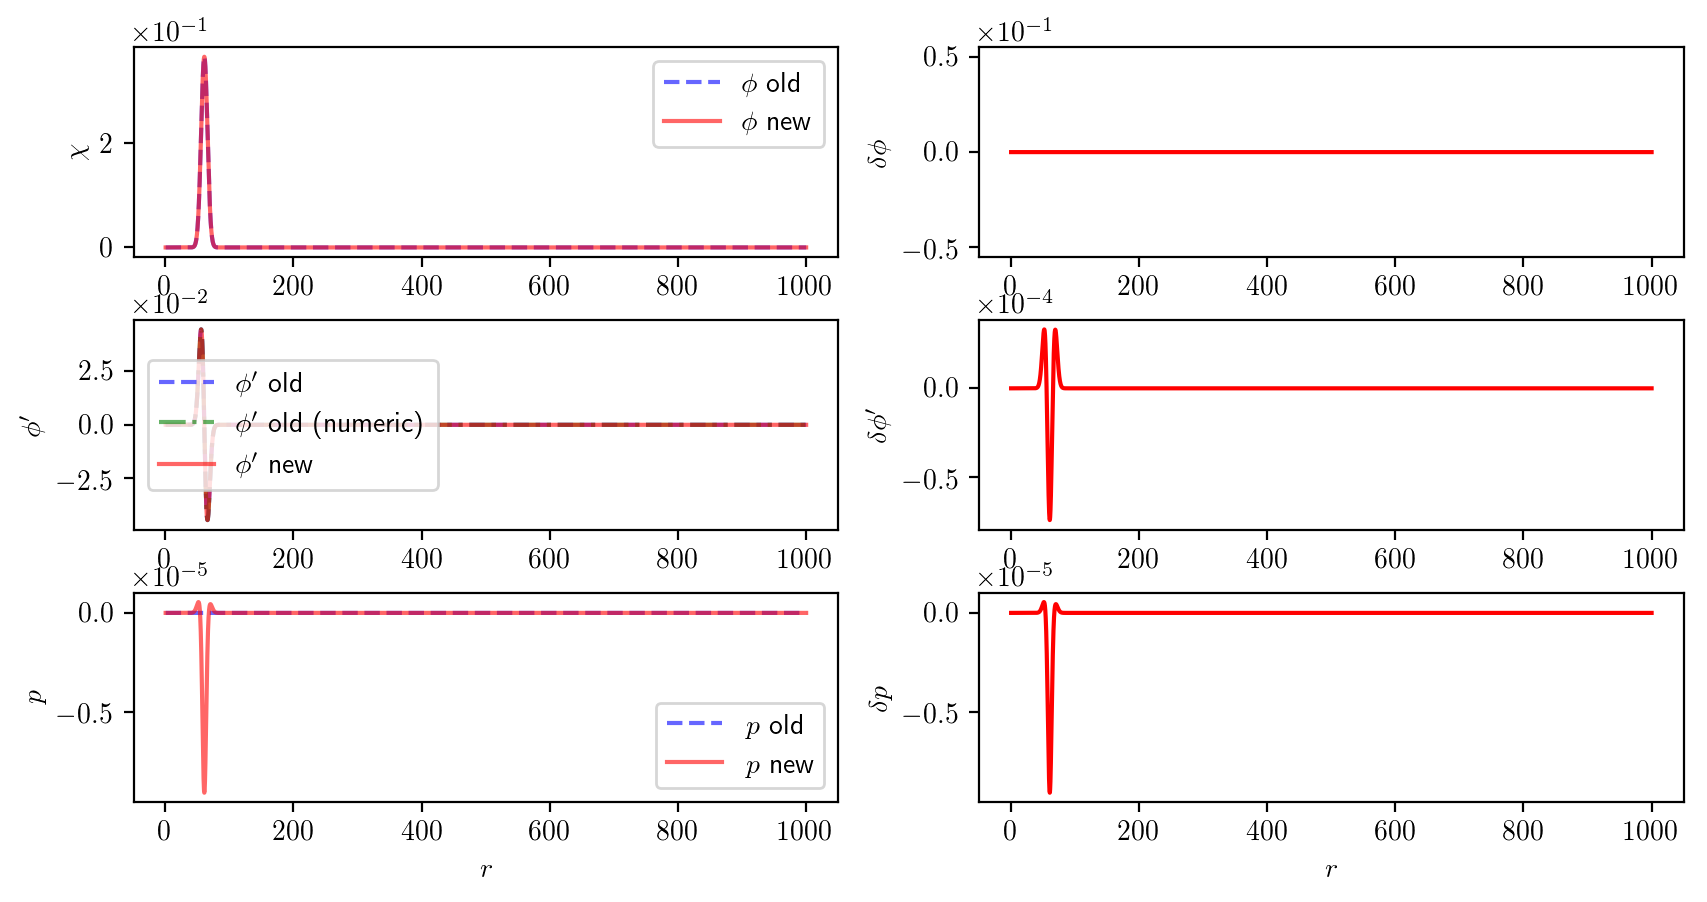

-------------------------------------------------
Metric contents
CPU times: user 150 ms, sys: 7 ms, total: 157 ms
Wall time: 170 ms


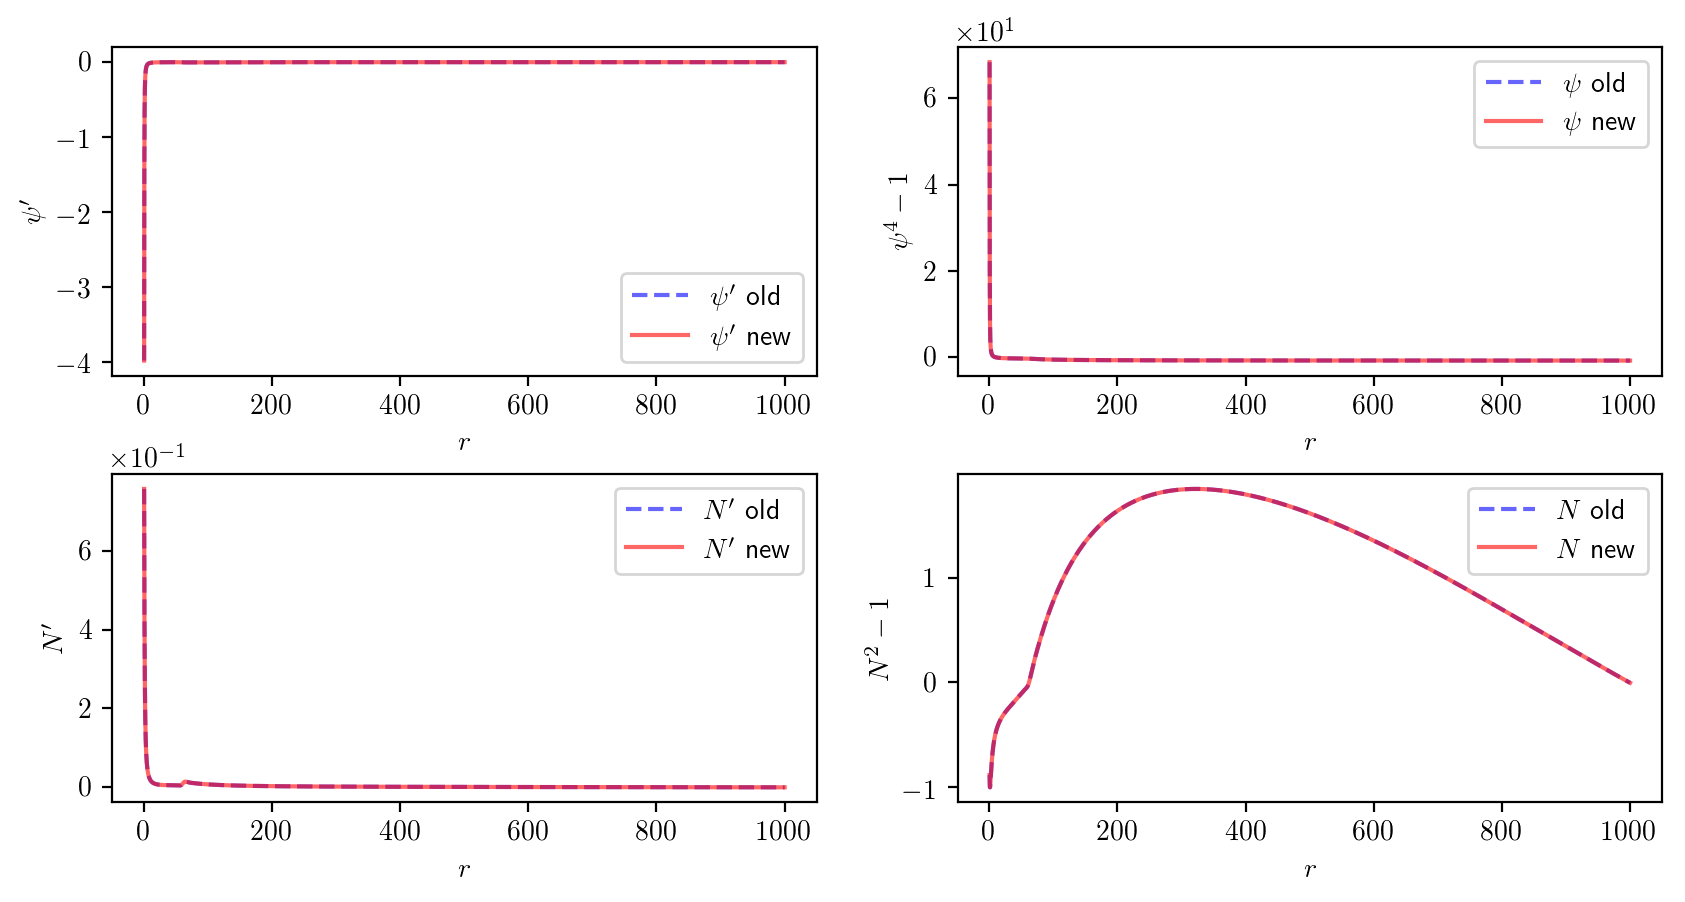

In [452]:
r_i = rr[0]; r_f = rr[-1];

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

phi_dr_grid_old = df_dx(rr, phi_f_init)
phi_dr_f_old = interp_funct(rr, phi_dr_grid_old)
        
ax[0,0].plot(rr, phi_f_init(rr), '--', label='$\phi$ old',color='blue', alpha=0.6);
ax[0,0].plot(rr, phi_f_new(rr), label='$\phi$ new',color='red', alpha=0.6);
ax[0,0].set_ylabel('$\chi$'); ax[0,0].legend();

ax[0,1].plot(rr, phi_f_new(rr)-phi_f_init(rr), color='red'); ax[0,1].set_ylabel('$\delta\phi$');

ax[1,0].plot(rr, phi_dr_f_init(rr), '--', label='$\phi\'$ old',color='blue', alpha=0.6);
ax[1,0].plot(rr, phi_dr_f_old(rr), '-.', label='$\phi\'$ old (numeric)',color='green', alpha=0.6);
ax[1,0].plot(rr, phi_dr_f_new(rr), label='$\phi\'$ new',color='red', alpha=0.6);
ax[1,0].set_ylabel('$\phi\'$'); ax[1,0].legend();

ax[1,1].plot(rr, phi_dr_f_new(rr)-phi_dr_f_init(rr), color='red'); ax[1,1].set_ylabel('$\delta\phi\'$');

ax[2,0].plot(rr, p_f_init(rr), '--', label='$p$ old',color='blue', alpha=0.6);
ax[2,0].plot(rr, p_f_new(rr), label='$p$ new',color='red', alpha=0.6);
ax[2,0].set_ylabel('$p$'); ax[2,0].legend();

ax[2,1].plot(rr, p_f_new(rr),color='red'); ax[2,1].set_ylabel('$\delta p$');

print("Matter field contents")
plt.show()

print("-------------------------------------------------")
print("Metric contents")



if reverse_bnd:
    %time ret_full = nint.solve_ivp(fun_r_solve, (r_f , r_i), x_return, method='RK45', \
                                    t_eval=rr[::-1], rtol=1e-6, atol=1e-8)
else: 
    %time ret_full = nint.solve_ivp(fun_r_solve, (r_i , r_f), x_return, method='RK45', \
                                    t_eval=rr, rtol=1e-6, atol=1e-8)
    
A_out_new = ret_full.y[0]; B_out_new = ret_full.y[1]; psi_out_new = ret_full.y[2]; N_out_new = ret_full.y[3];

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.2, hspace=0.3)
for row in ax:
    for col in row:
       col.set_xlabel('$r$')
       col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[0,0].plot(ret_full.t, A_f_init(ret_full.t)/(ret_full.t**2), '--', label='$\psi\'$ old',color='blue', alpha=0.6);
ax[0,0].plot(ret_full.t, A_out_new/(ret_full.t**2), label='$\psi\'$ new',color='red', alpha=0.6);
ax[0,0].set_ylabel('$\psi\'$'); ax[0,0].legend();

ax[1,0].plot(ret_full.t, ret_full.t*B_f_init(ret_full.t)*(psi_f_init(ret_full.t)**4), '--', label='$N\'$ old', color='blue', alpha=0.6);
ax[1,0].plot(ret_full.t, ret_full.t*B_out_new*(psi_out_new**4), label='$N\'$ new', color='red', alpha=0.6);
ax[1,0].set_ylabel('$N\'$'); ax[1,0].legend();

ax[0,1].plot(ret_full.t, psi_f_init(ret_full.t)**4-1., '--', label='$\psi$ old', color='blue', alpha=0.6);
ax[0,1].plot(ret_full.t, psi_out_new**4-1., label='$\psi$ new',color='red', alpha=0.6);
ax[0,1].set_ylabel('$\psi^4 - 1$'); ax[0,1].legend();

ax[1,1].plot(ret_full.t, N_f_init(ret_full.t)**2-1., '--', label='$N$ old',color='blue', alpha=0.6);
ax[1,1].plot(ret_full.t, N_out_new**2-1., label='$N$ new',color='red', alpha=0.6);
ax[1,1].set_ylabel('$N^2 - 1$'); ax[1,1].legend();

plt.show()

## Time-dependent black hole solution

In [394]:
bnd_dnf = lambda n: rr[-1]**n

def fun_t(r, y, dt, t=None, verbose=False):
    
    A_f_in = y[0]; B_f_in = y[1]; psi_f_in = y[2]; N_f_in = y[3];
    vevsq_in = y[4]; phi_f_in = y[5]; p_f_in = y[6]; phi_dr_f_in = y[7]; K_f_in = y[8]

    vevsq_out = vevsq_in
    
    phi_drdr_in = ddf_dxdx(r, phi_f_in, -5)
    
    phi_dt = dphi_dt(N_f_in(r), psi_f_in(r), p_f_in(r))
    p_dt = dp_dt(r, N_f_in(r), psi_f_in(r), phi_f_in(r), A_f_in(r), B_f_in(r), phi_dr_f_in(r), phi_drdr_in, vevsq_out)
    K_dt = dK_dt(r, N_f_in(r), A_f_in(r), B_f_in(r), K_f_in(r), psi_f_in(r), phi_f_in(r), p_f_in(r), phi_dr_f_in(r), vevsq_out)
                  
    K_out = K_f_in(r) + K_dt*dt
    p_out = p_f_in(r) + p_dt*dt
    phi_out = phi_f_in(r) + phi_dt*dt
    
    halflen = int(len(r)/2)
    phi_f_out = interp_funct(r, phi_out)
    phi_dr_out = df_dx(r, phi_f_out, -4.)

    phi_dr_f_out = interp_funct(r, phi_dr_out)
    p_f_out = interp_funct(r, p_out)
    K_f_out = interp_funct(r, K_out)

    init_metric_input = [A_f_in(r[0]), B_f_in(r[0]), psi_f_in(r[0]), N_f_in(r[0])]
    
    fun_r_solve = lambda r, y: fun_r(r, y, [vevsq_out, phi_f_in, p_f_in, phi_dr_f_in, K_f_in])
    
    if not reverse_bnd:
        offs = [psi_r_s( r[-1] ), N_r_s( r[-1] ), psi_s( r[-1] ), N_s( r[-1] )]
        bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.)]
        result = opt.minimize(shoot_r, init_input, args=(r, bnds, offs), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})
    else:
        offs = [psi_r_s( r[0] ), N_r_s( r[0] ), psi_s( r[0] ), N_s( r[0] )]
        bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]
        result = opt.minimize(shoot_r, init_input, args=(r, bnds, offs, True), method='Powell', \
                                options={'xtol':1e-5, 'ftol':1e-5})

    if not result["success"]:
        print("Error: Minimizer failed!")
        return False


    if reverse_bnd:
        ret_full = nint.solve_ivp(fun_r_solve, (r[-1] , r[0]), x_return, method='RK45', \
                                    t_eval=r[::-1], rtol=1e-6, atol=1e-8)
    else: 
        ret_full = nint.solve_ivp(fun_r_solve, (r[0] , r[-1]), x_return, method='RK45', \
                                    t_eval=r, rtol=1e-6, atol=1e-8)

    A_out = ret_full.y[0]; B_out = ret_full.y[1]; psi_out = ret_full.y[2]; N_out = ret_full.y[3];
    
    if verbose:
        print("The optimized inital values are: " + str(x_return))
        print("The result distance is: " + str(result["fun"]))
        
    A_f_out = interp_funct(ret_full.t, A_out)
    B_f_out = interp_funct(ret_full.t, B_out)
    psi_f_out = interp_funct(ret_full.t, psi_out)
    N_f_out = interp_funct(ret_full.t, N_out)
    

    return [A_f_out, B_f_out, psi_f_out, N_f_out, vevsq_out, phi_f_out, p_f_out, phi_dr_f_out, K_f_out]

In [397]:
"""kap = 0.1
lamb = 3.
m2chi = 1.

r_min = 1e-2
r_max = 30 + r_min
r_div = int(1e3)"""

rr = np.linspace(r_min, r_max, r_div)

phi_init_grid = 0.001*np.exp(-(rr-20.)**2/50.)*rr**2 #8.*lamb*(rr**4)/((lamb**2)+(rr**2))**4
p_init_grid = 0.*rr
phi_dr_init_grid = 0.001*(2*rr - 2.*(rr-20)*(rr**2/50))*np.exp(-(rr-20.)**2/50.) #32.*lamb*(rr**3)/((lamb**2)+(rr**2))**4 - 64.*lamb*(rr**5)/((lamb**2)+(rr**2))**5
K_init_grid = 0.*rr

phi_init = interp_funct(rr, phi_init_grid)
p_init = interp_funct(rr, p_init_grid)
phi_dr_init = interp_funct(rr, phi_dr_init_grid)
K_init = interp_funct(rr, K_init_grid)

init_input = np.array([psi_r_s(r_min)*r_min**2, N_r_s(r_min)/(r_min*psi_s(r_min)**4), psi_s(r_min), N_s(r_min)])


r_i = rr[0]; r_f = rr[-1];

fun_r_solve = lambda r, y: fun_r(r, y, [vevsq, phi_init, p_init, phi_dr_init, K_init])

if not reverse_bnd:
    offs = [psi_r_s( rr[-1] ), N_r_s( rr[-1] ), psi_s( rr[-1] ), N_s( rr[-1] )]
    bnds = [0.5*bnd_dnf(0.), bnd_dnf(0.), 0.5*bnd_dnf(0.), bnd_dnf(0.)]
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs), method='Powell', \
                            options={'xtol':1e-6, 'ftol':1e-6})
else:
    offs = [psi_r_s( rr[0] ), N_r_s( rr[0] ), psi_s( rr[0] ), N_s( rr[0] )]
    bnds = [0.5*bnd_dnf(-2.), bnd_dnf(-2.), 0.5*bnd_dnf(-1.), bnd_dnf(-1.)]
    %time result = opt.minimize(shoot_r, init_input, args=(rr, bnds, offs, True), method='Powell', \
                            options={'xtol':1e-6, 'ftol':1e-6})

if result["success"]:
    x_return = result["x"]
    print("The optimized inital values are: " + str(x_return))
    print("The result distance is: " + str(result["fun"]))

%time ret_full = nint.solve_ivp(fun_r_solve, (r_i , r_f), x_return, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-8)

if not reverse_bnd:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_i , r_f), x_return, method='RK45', t_eval=rr, rtol=1e-6, atol=1e-8)
else:
   %time ret_full = nint.solve_ivp(fun_r_solve, (r_f , r_i), x_return, method='RK45', t_eval=rr[::-1], rtol=1e-6, atol=1e-8)


A_init_grid = ret_full.y[0]; B_init_grid = ret_full.y[1]; psi_init_grid = ret_full.y[2]; N_init_grid = ret_full.y[3];

A_init = interp_funct(rr, A_init_grid)
B_init = interp_funct(rr, B_init_grid)
psi_init = interp_funct(rr, psi_init_grid)
N_init = interp_funct(rr, N_init_grid)

CPU times: user 24.3 s, sys: 190 ms, total: 24.5 s
Wall time: 24.6 s
The optimized inital values are: [ -5.00761977e-01   1.24993701e-01   2.00000248e+00   9.97222770e-07]
The result distance is: 0.192021121779
CPU times: user 77.6 ms, sys: 1.08 ms, total: 78.7 ms
Wall time: 79.1 ms
CPU times: user 78.7 ms, sys: 2.03 ms, total: 80.7 ms
Wall time: 81.6 ms


Running the result for *t_end* amount of time in *dt* time steps.

In [398]:
tend = 1e-2

vec_t = [A_init, B_init, psi_init, N_init, vevsq, phi_init, p_init, phi_dr_init, K_init]
t_all = np.array(vec_t)
t_size = np.array([0.])
t_now = t_size[-1]

dt_0 =1e-4; tswtich_0 = 1e-2
dt_1 = dt_0/10.; tswtich_1 = 9e-4
for t_step in tqdm(range(int(tend/dt_0))):
    if t_now >= 0.:
        dt = dt_0
    #if t_now >= tswtich_0:
    #    dt = dt_1
    t_now = t_size[-1]+dt
    vec_t = fun_t(rr, vec_t, dt, t_now)
    t_all = np.vstack((t_all, vec_t))
    t_size = np.hstack((t_size, t_now))


 93%|█████████▎| 93/100 [40:28<03:02, 26.12s/it]/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply



KeyboardInterrupt: 

Using dt=1e-4, noise starts to build up in $p$ at t = 1.5e-3.
Using dt=1e-5, noise starts to build up in $p$ at t = 1e-3.

Plotting the result

In [399]:
def plot_t_slice(t_slices, r):
    plot_alpha = 0.7
    
    result = t_all[t_slices]
    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    A_result = result[:,0]; B_result = result[:,1]; psi_result = result[:,2]; N_result = result[:,3]
    vev_end = result[:,4];
    phi_result = result[:,5]; p_result = result[:,6]; phi_dr_result = result[:,7]; K_result = result[:,8]

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.3)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        ax[0,0].plot(r, phi_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$\chi$'); #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        phi_dr_grid_old = df_dx(r, phi_result[i])
        ax[0,1].plot(r, phi_dr_grid_old, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,1].set_ylabel('$\chi\'$ (numeric)'); ax[0,1].legend();
    
    for i, t_slice in enumerate(t_slices):
        ax[1,1].plot(r, phi_dr_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$\chi\'$'); ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        ax[1,0].plot(r, p_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$p$'); #ax[1,0].legend();

    print("Matter field contents")
    plt.show()

    print("-------------------------------------------------")
    print("Metric contents")

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,5))
    plt.subplots_adjust(wspace = 0.2, hspace=0.3)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        ax[0,0].plot(r, A_result[i](r)/(r**2), label=('t = ' + str(t_slice)),color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$\psi$\'');  #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        ax[0,1].plot(r, r*B_result[i](r)*(psi_result[i](r)**4), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,1].set_ylabel('$N$\'');  #ax[0,1].legend();
    
    for i, t_slice in enumerate(t_slices):
        ax[1,0].plot(r, psi_result[i](r)**4-1, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$\psi$'); #ax[1,0].legend();

    for i, t_slice in enumerate(t_slices):
        ax[1,1].plot(r, N_result[i](r)**2-1, label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$N$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        ax[2,0].plot(r, K_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$K$'); #ax[2,0].legend();
    
    """for i, t_slice in enumerate(t_slices):
        if t_slice == 0: continue
        dpsi_result_dt = (psi_result[i](r)-psi_result[i-1](r))/dt
        ax[2,1].plot(r, -6.*dpsi_result_dt/(N_result[i](r)*psi_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('$K$ Numeric'); #ax[2,1].legend();"""
    for i, t_slice in enumerate(t_slices):
        ax[2,1].plot(r, ddf_dxdx(r, psi_result[i], -1.), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('$\psi$\" Numeric')
    
    plt.show()
    return

In [ ]:
save_file = "bh_result.csv"

rr_plot= np.linspace(r_min, r_max, 100)

A_result = t_all[:,0]; B_result = t_all[:,1]; psi_result = t_all[:,2]; N_result = t_all[:,3]
vev_end = t_all[:,4];
phi_result = t_all[:,5]; p_result = t_all[:,6]; phi_dr_result = t_all[:,7]; K_result = t_all[:,8]

data = np.array([])
for i, t_save in enumerate(t_size):
    for j, r_save in enumerate(rr_plot):
        data_save = np.array([ t_save, r_save, A_result[i](r_save), B_result[i](r_save), \
                              psi_result[i](r_save), N_result[i](r_save), phi_result[i](r_save), \
                             p_result[i](r_save), phi_dr_result[i](r_save), K_result[i](r_save)])
        if i == 0 and j ==0:
            data = data_save
        else:
            data = np.vstack((data, data_save))

line_header = "# t, r, A, B, psi, N, phi, p, phi\', K"
np.savetxt(save_file, data, delimiter=',',header=line_header)

('length of time steps: ', 94)
Matter field contents


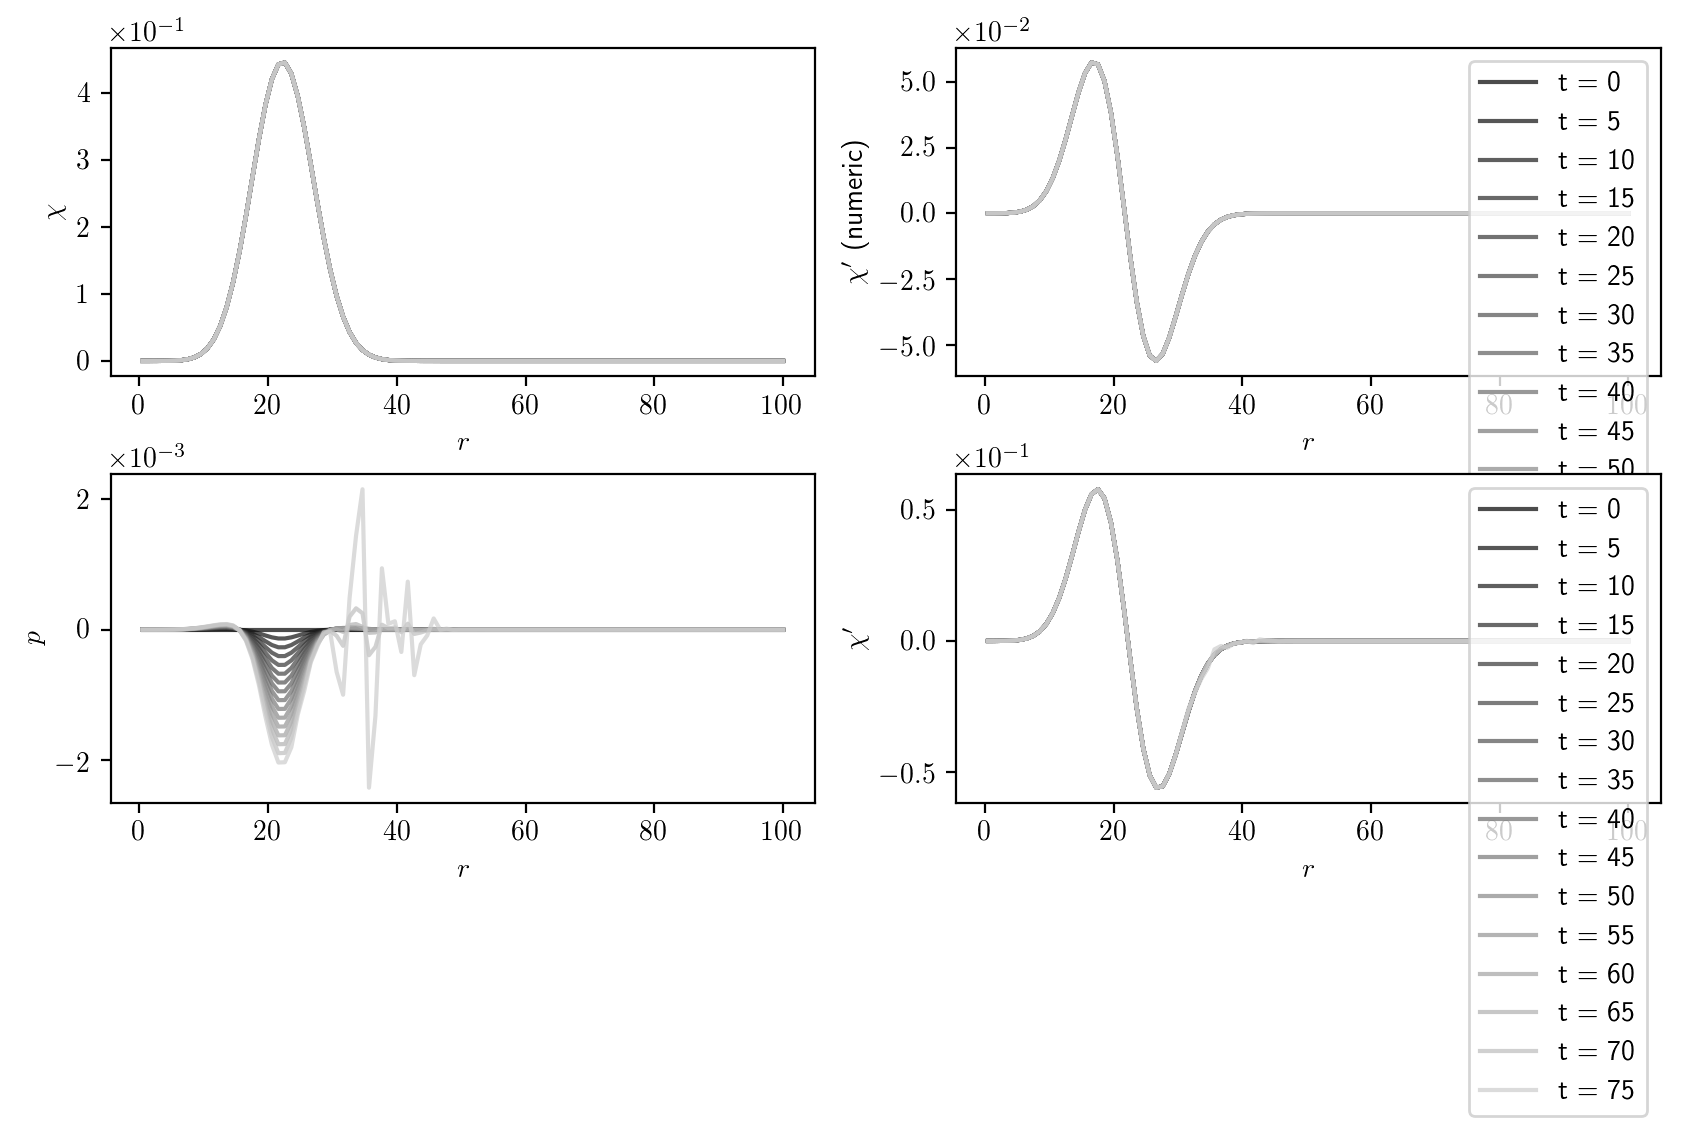

-------------------------------------------------
Metric contents


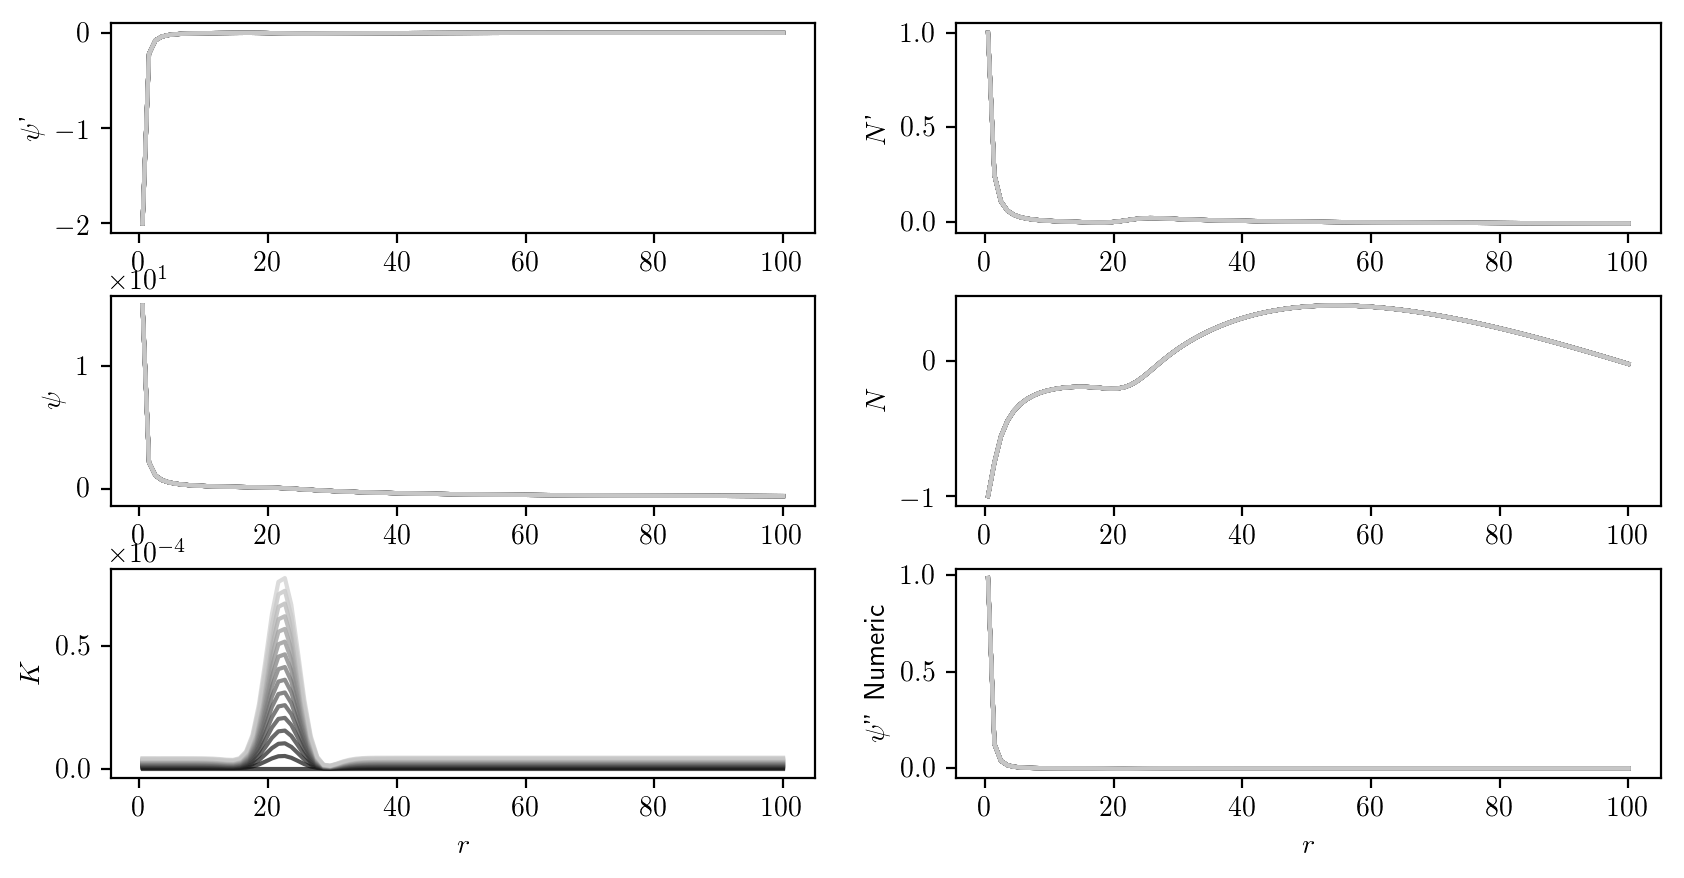

In [404]:
rr_plot = np.linspace(r_min, r_max, 100)
print("length of time steps: ", len(t_all))
plot_t_slice(range(0,80,5),rr_plot)
#plot_t_slice([1,1000],rr_plot)